ITERATIVE FUNCTION

#We have the NU as the input, and it returns Y as the output. So we want to iterate that but changing the NU

In [1]:
import os
import numpy as np
from DMF_model import DMF_sim, DMF_parameters

In [2]:
# Create folder to store the results
folder = "COMBIS"
folder_path = os.path.join(os.getcwd(), folder)
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [3]:
# DMF parameters
P = DMF_parameters({})
P['sigma'] = 0.02  # no noise

# Simulation parameters   
t_sim = 3 # simulation time
t_start = 0.5 # stimulation start time
t_stop = 2.5 # stimulation stop time
dt = P['dt']     # integration time step
P['T'] = t_sim

transient_end = int(0.1/dt) # end of initial transient

# layer specific external input
stim_start = int(t_start/dt)    # start of stimulation
stim_end   = int(t_stop/dt)    # end of stimulation
sim_steps = int(t_sim/dt)       # number of simulation steps

stim_index = range(stim_start,stim_end) # indices of stimulation
input_template = np.zeros(sim_steps) # input current
input_template[stim_index] = 1.0 # input current during stimulation (later just multiply with the specific input intensity)

# Define the possible values for each input intensity.
valuesI = [50, 100, 150, 200, 250, 300]
valuesLayer = range(8)

create_combinations = False
if create_combinations:
    # Create an array of all possible combinations for each input
    input_combinations = np.array(np.meshgrid(valuesI, valuesI)).T.reshape(-1, 2)
    layer_combinations = np.array(np.meshgrid(valuesLayer, valuesLayer)).T.reshape(-1, 2)
    
    # repeat each input combination for each layer combination
    input_combinations = np.repeat(input_combinations, len(layer_combinations), axis=0)
    layer_combinations = np.tile(layer_combinations, (len(valuesI)**2, 1))
    
    # repeat each input combination and layer combination 5 times
    input_combinations = np.repeat(input_combinations, 5, axis=0)
    layer_combinations = np.repeat(layer_combinations, 5, axis=0)
    
    # Create random input combinations centered around the original input combinations
    input_combinations = input_combinations + np.random.uniform(-50, 49, input_combinations.shape)
    
    # Put it in the correct format for the machine learning group.

    total_combinations = np.zeros((input_combinations.shape[0],8))
    total_combinations[np.arange(input_combinations.shape[0]).reshape(-1, 1), layer_combinations] = input_combinations
    
    # save input and layer combinations
    np.save(os.path.join(folder_path, "input_combinations.npy"), input_combinations)
    np.save(os.path.join(folder_path, "layer_combinations.npy"), layer_combinations)
    np.save(os.path.join(folder_path, "total_combinations.npy"), total_combinations)
    
else:
    input_combinations = np.load(os.path.join(folder_path, "input_combinations.npy"))
    layer_combinations = np.load(os.path.join(folder_path, "layer_combinations.npy"))

In [6]:
# The loop

baseline_duration_added = 10
baseline_duration_steps = int(baseline_duration_added/dt)
baseline = np.load("baseline.npy")
baseline = baseline[:baseline_duration_steps,:]

duration = sim_steps - transient_end 
total_number_combinations = len(input_combinations)

# divide the total number of combinations into 10 batches and save each batch separately
batch_size = int(total_number_combinations/10)
Y_baseline = np.tile(baseline, (batch_size,1,1))

Y = np.zeros((batch_size, duration, 8))
batch_counter = 0  # counter of simulation in current batch
batch_number = 1  # which batch are we currently running (for file naming)
for total_counter, (current, layer) in enumerate(zip(input_combinations, layer_combinations)):
    if (total_counter + 1) % 100 == 0:
        print(f"Running simulation {total_counter+1}/{input_combinations.shape[0]}")
    U = np.zeros((sim_steps, 8))
    U[:, layer[0]] = input_template * current[0]
    U[:, layer[1]] = input_template * current[1]

    # Run the simulation
    I, _, _ = DMF_sim(U, P)
    Y[batch_counter, :, :] = I[transient_end:, :]
    batch_counter += 1
    # save if current batch is finished or all simulations are created
    if (total_counter + 1) % batch_size == 0 or total_counter == (input_combinations.shape[0] - 1):
        
        # Save the results and include the batch number in the file name with leading zeros
        # note that the baseline is not saved with the simulation to avoid large files
        np.save(os.path.join(folder_path, f'Y_{batch_number:02d}.npy'), Y)
        
        Y = np.zeros((batch_size, duration + baseline_duration_steps, 8))
        batch_counter = 0
        batch_number += 1
        break # To run only first full batch

Running simulation 100/11520


KeyboardInterrupt: 

### Example how to add the baseline for processing later

In [19]:
import pylab as plt

file_path = os.path.join(folder_path, "Y_01.npy")
Y01 = np.load(file_path)

print(Y01.shape)
simulation_sampling_rate=1e-4

baseline_duration_added = 10
baseline_duration_steps = int(baseline_duration_added/simulation_sampling_rate)
baseline = np.load("baseline.npy")
baseline = baseline[:baseline_duration_steps,:]

duration = Y01.shape[1]

batch_size = Y01.shape[0]
Y_baseline = np.tile(baseline, (batch_size,1,1))

Y_with_baseline = np.concatenate([Y01, Y_baseline], axis=1)

# plot to check
populations = np.array(['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'])
colors      = plt.cm.Spectral(np.linspace(0, 1, len(populations)))
plt.figure(figsize=(10, 6))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Spectral(np.linspace(0, 1, 8))))
plt.title('Y')
plt.plot(Y_with_baseline[0,:,:])
# plt.xlim([0, len(duration + baseline_duration_steps)-1])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/computer_classes/MSB1013_ComputationalNeuroscience/Neurons_Simulations/COMBIS/Y_01.npy'

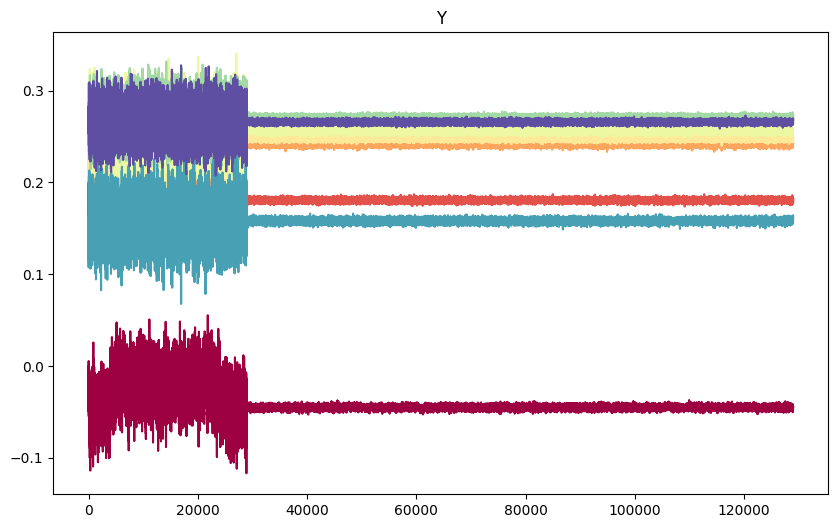

In [14]:
# Making the graph

import pylab as plt

file_path = os.path.join(folder_path, "Y_03.npy") # This is the file for the first batch
Y03 = np.load(file_path)

populations = np.array(['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'])
colors      = plt.cm.Spectral(np.linspace(0, 1, len(populations)))
plt.figure(figsize=(10, 6))
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Spectral(np.linspace(0, 1, 8))))
plt.title('Y')
plt.plot(Y03[0,:,:])
# plt.xlim([0, len(duration + baseline_duration_steps)-1])
plt.show()